# Sentiment analysis of Handwritten Text

## OCR

### All the required libraries

In [1]:
## Importing libraries

# Loading the data file and data manipulation
import pandas as pd

# To play with arrays
import numpy as np

# To load and save the data
import pickle

from tensorflow import keras
import tensorflow as tf


2024-07-06 10:54:12.273848: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 10:54:12.277303: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:54:12.290483: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-06 10:54:12.335022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 10:54:12.423178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

### Cleaning up the data file

In [2]:
# # Read the CSV file to get the headers
# with open('Data/alphabets_28x28.csv', 'r') as file:
#     headers = file.readline().strip()

# # Initialize a list to store valid rows
# valid_rows = [headers]

# # Read the CSV file line by line and filter out invalid rows
# with open('Data/alphabets_28x28.csv', 'r') as file:
#     headers = file.readline().strip()
#     for line in file:
#         # Split the line by comma
#         row = line.strip().split(',')
#         # Check if the number of elements matches the number of headers
#         if len(row) == len(headers.split(',')):
#             valid_rows.append(line.strip())

# # Write the valid rows back to a new CSV file
# with open('Data/data.csv', 'w') as file:
#     for row in valid_rows:
#         file.write(row + '\n')

### Loading the data

In [2]:
# Read the CSV file
data = pd.read_csv('Data/data.csv')

In [3]:
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

In [5]:
print(X.shape)
print(y.shape)

(371391, 784)
(371391,)


In [4]:
del data

In [5]:
X = X.astype('float64')

### Preprocessing the data

In [5]:
# Check for any negative values
negative_count = (X < 0).sum().sum()
print(f"Number of negative values: {negative_count}")

# Check for any values above 255 (assuming 8-bit grayscale images)
above_255_count = (X > 255).sum().sum()
print(f"Number of values above 255: {above_255_count}")

Number of negative values: 0
Number of values above 255: 0


In [6]:
# Normalizing the data
X = X / 255.0

data_count = ((X >= 0) & (X <= 1)).sum().sum()
print(f"Number data_count: {data_count}")
print(f"Total no. of cells: {X.shape[0] * X.shape[1]}")

Number data_count: 291170544
Total no. of cells: 291170544


In [18]:
num_classes = int(len(set(y)))
print(f"Number of classes: {num_classes}")

Number of classes: 26


In [7]:
print(y[:10])
print(y[-10:])
# Create character to integer mapping
char_to_int = {char: i for i, char in enumerate(sorted(set(y)))}
int_to_char = {i: char for char, i in char_to_int.items()}

# Convert characters to integers
y_int = np.array([char_to_int[char] for char in y])

print([int_to_char[i] for i in y_int[:10]])
print([int_to_char[i] for i in y_int[-10:]])

['A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A']
['Z' 'Z' 'Z' 'Z' 'Z' 'Z' 'Z' 'Z' 'Z' 'Z']
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']


In [8]:
del y

### Splitting the data

In [9]:
# import libraries
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_int, test_size=0.2, random_state=42)


In [12]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(297112, 784)
(37140, 784)
(297112,)
(37140,)
(37139, 784)
(37139,)


### Checkpoint to save and load all the data till now

In [15]:
checkpoint1 = [char_to_int, int_to_char, X_train, X_test, y_train, y_test, X_val, y_val]

with open('check1.pkl', 'wb') as f:
    pickle.dump(checkpoint1, f)

In [24]:
with open('check1.pkl', 'rb') as f:
    checkpoint1 = pickle.load(f)

char_to_int, int_to_char, X_train, X_test, y_train, y_test, X_val, y_val = checkpoint1

In [26]:
with open('main.pkl', 'wb') as f:
    pickle.dump([char_to_int, int_to_char], f)

### Have to load this

In [27]:
with open('main.pkl', 'rb') as f:
    char_to_int, int_to_char = pickle.load(f)

In [56]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(297112, 28, 28, 1)
(37140, 28, 28, 1)
(37139, 28, 28, 1)


### Making the model to recongnize the text

In [21]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(26)
])

model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
9285/9285 ━━━━━━━━━━━━━━━━━━━━ 242s 26ms/step - accuracy: 0.9249 - loss: 0.2623 - val_accuracy: 0.9790 - val_loss: 0.0722
Epoch 2/5
9285/9285 ━━━━━━━━━━━━━━━━━━━━ 238s 26ms/step - accuracy: 0.9853 - loss: 0.0515 - val_accuracy: 0.9868 - val_loss: 0.0444
Epoch 3/5
9285/9285 ━━━━━━━━━━━━━━━━━━━━ 240s 26ms/step - accuracy: 0.9897 - loss: 0.0343 - val_accuracy: 0.9871 - val_loss: 0.0455
Epoch 4/5
9285/9285 ━━━━━━━━━━━━━━━━━━━━ 243s 26ms/step - accuracy: 0.9924 - loss: 0.0257 - val_accuracy: 0.9897 - val_loss: 0.0355
Epoch 5/5
9285/9285 ━━━━━━━━━━━━━━━━━━━━ 242s 26ms/step - accuracy: 0.9935 - loss: 0.0210 - val_accuracy: 0.9911 - val_loss: 0.0334


### Have to also load this.

In [22]:
def predict_character(model, image):
    logits = model.predict(image[np.newaxis, ...])
    predicted_class = np.argmax(logits)
    return int_to_char[predicted_class]

In [60]:
# Example usage
random_number = np.random.randint(0, X_test.shape[0])
print(X_test[random_number])
sample_image = X_test[random_number]
print(f"Predicted character: {predict_character(model, sample_image)}")
print(f"Actual character: {int_to_char[y_test[random_number]]}")

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

In [31]:
# check accuracy of model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

1161/1161 - 12s - 10ms/step - accuracy: 0.9914 - loss: 0.0314

Test accuracy: 0.9914108514785767


### Save the model

In [34]:
# save the model
model.save('model.h5')
model.save('mymodel.keras')

In [2]:
# load the model
model = keras.models.load_model('mymodel.keras')

/home/shravan/anaconda3/envs/DA/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Image into text converter

### Libraries required and visualization of the image

In [3]:
import cv2
import matplotlib.pyplot as plt

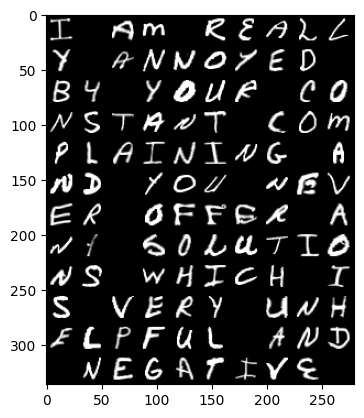

In [4]:
# Load the image and show the image inline
image = cv2.imread('Data/target_images/line_1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

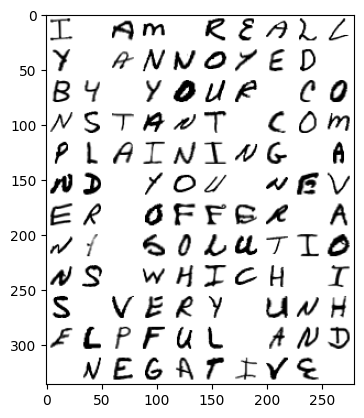

In [7]:
image_inv = cv2.bitwise_not(image)
plt.imshow(image_inv, cmap='gray')
plt.show()

### Preprocessing the image

In [5]:
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    # Apply thresholding to create a binary image
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert the binary image (white background, black characters)
    inverted_binary_image = cv2.bitwise_not(binary_image)
    return inverted_binary_image


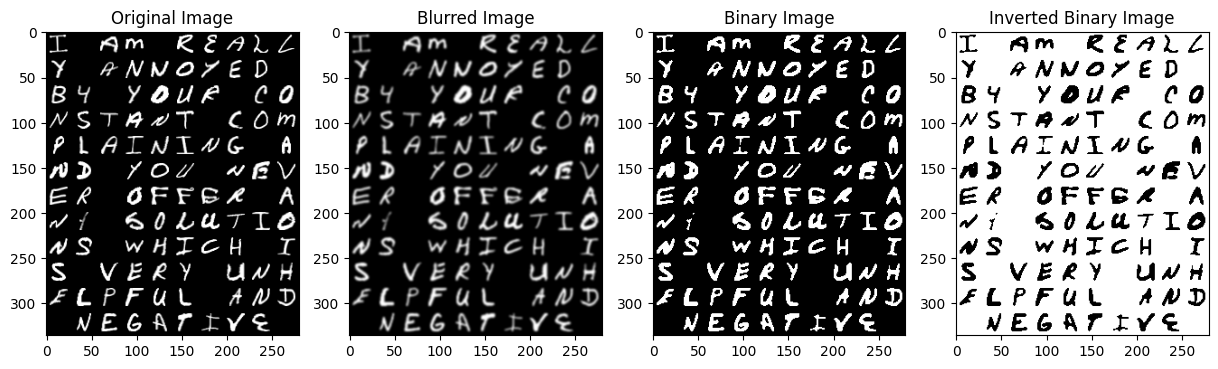

In [9]:
## output of the preprocess_image function on line_1.png

### Segmenting Words

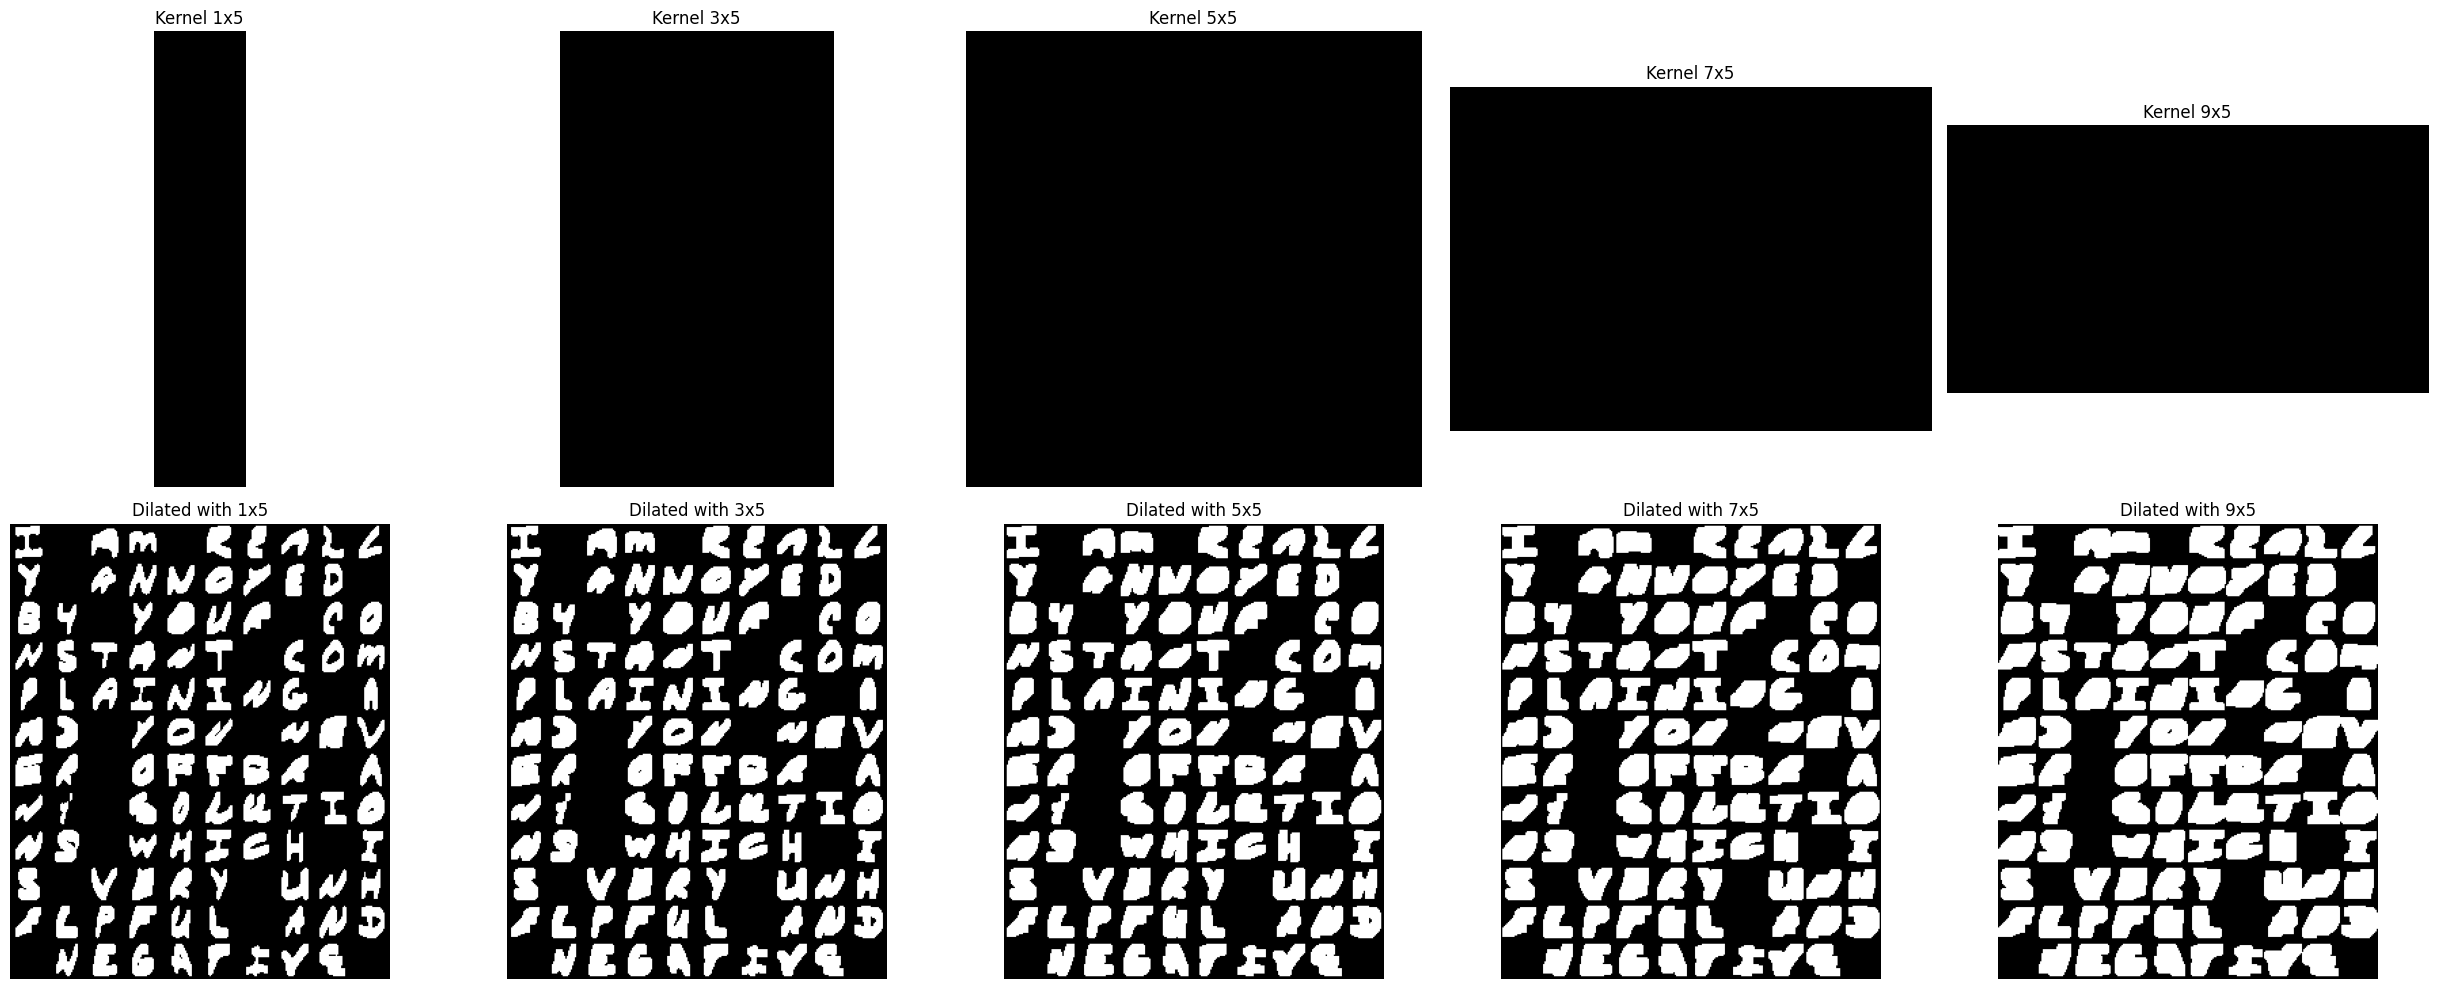

In [16]:
def visualize_kernels(image, kernel_sizes):
    """
    Visualize the effects of different kernel sizes on dilation.
    
    :param image: Input binary image
    :param kernel_sizes: List of kernel sizes to test
    """
    n = len(kernel_sizes)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 10))
    
    for i, size in enumerate(kernel_sizes):
        kernel = np.ones((5, size), np.uint8)  # Fixed height of 5, varying width
        
        # Visualize the kernel
        axes[0, i].imshow(kernel, cmap='gray')
        axes[0, i].set_title(f'Kernel {size}x5')
        axes[0, i].axis('off')
        
        # Apply dilation and visualize result
        dilated = cv2.dilate(image, kernel, iterations=1)
        axes[1, i].imshow(dilated, cmap='gray')
        axes[1, i].set_title(f'Dilated with {size}x5')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

kernel_sizes = [1, 3, 5, 7, 9]
visualize_kernels(cv2.bitwise_not(preprocess_image('Data/target_images/line_1.png')), kernel_sizes)

In [6]:
def segment_words(image):
    # Assuming image is already binary (black text on white background)
    # If not, you might need to add binarization step
    
    # Invert the image (white text on black background)
    inv_image = cv2.bitwise_not(image)
    
    # Perform dilation to connect characters within words
    kernel = np.ones((5,18), np.uint8)  # Adjust kernel size as needed
    dilated = cv2.dilate(inv_image, kernel, iterations=1)
    
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get bounding boxes for all contours
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    # Sort bounding boxes: first by y-coordinate (with a tolerance), then by x-coordinate
    def sort_boxes(box):
        x, y, w, h = box
        return (y // 20) * 10000 + x  # Adjust 20 based on your line spacing
    
    bounding_boxes.sort(key=sort_boxes)
    
    word_images = []
    this_y = -1
    prev_word = None
    max_height = max(box[3] for box in bounding_boxes)
    print(image.shape[0])
    print(image.shape[1])

    def resize_to_height(img, target_height):
        ratio = target_height / img.shape[0]
        return cv2.resize(img, (int(img.shape[1] * ratio), target_height))
    
    for box in bounding_boxes:
        x, y, w, h = box
        word = image[y:y+h, x:x+w]
        word = resize_to_height(word, max_height)

        # New line
        if(y > this_y + 15):
            if prev_word is not None:
                if x < 15:
                    word = np.hstack((prev_word, word))
                else:
                    word_images.append(prev_word)
                    word_images.append(word)
                    prev_word = None
                    continue
            this_y = y
            if(x + w + 10 > image.shape[1]):
                prev_word = word
                continue
            else:
                prev_word = None
                word_images.append(word)
        else:
            if x+w+15 > image.shape[1]:
                prev_word = word
                continue
            else:
                prev_word = None
                word_images.append(word)
    
    # Add the last word
    if prev_word is not None:
        word_images.append(prev_word)

    return word_images

### demo of word segmentation

364
280
20


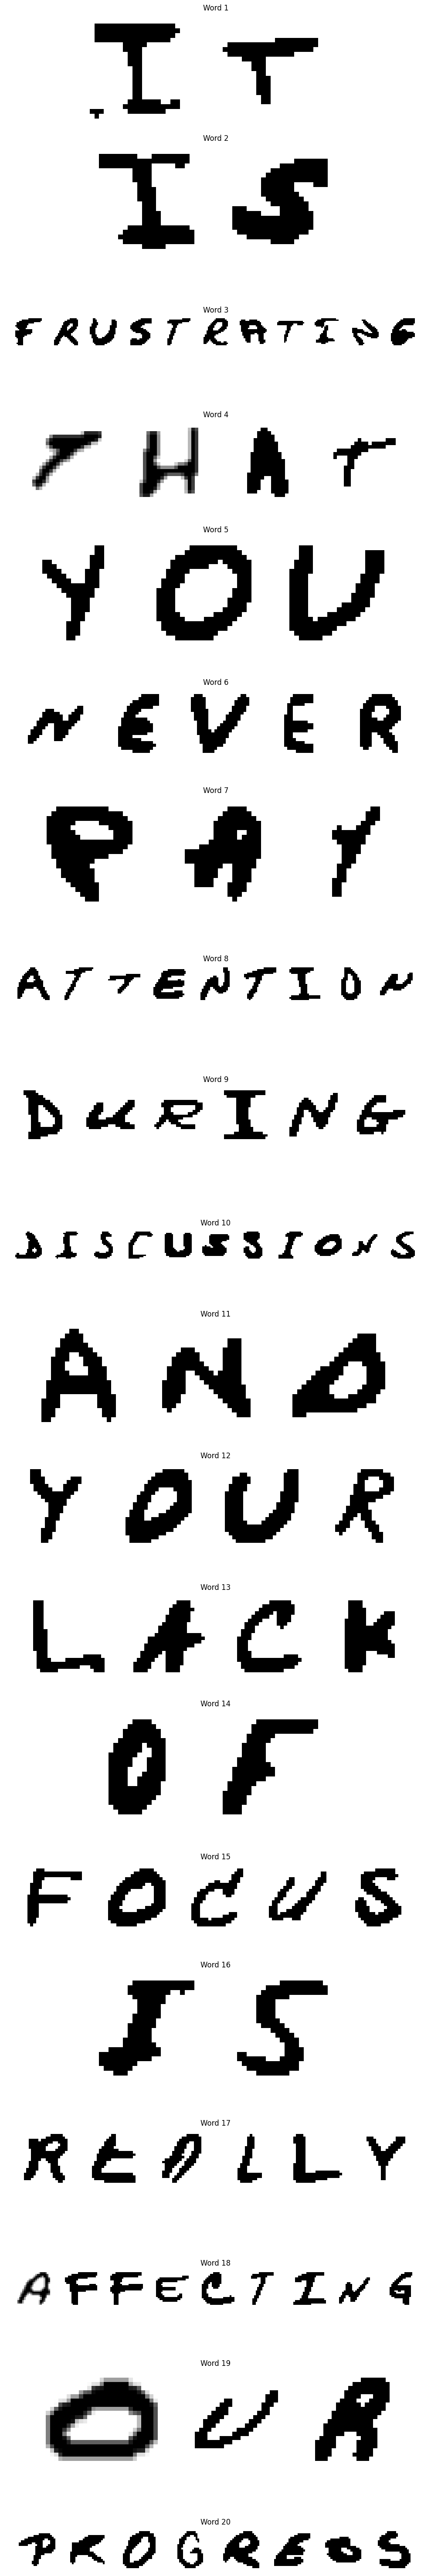

In [19]:
word_images = segment_words(preprocess_image('Data/target_images/line_2.png'))
print(len(word_images))
      
# Create a large enough subplot to hold all words
n_rows = len(word_images)
fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3*n_rows))
if n_rows == 1:
    axes = [axes]
    
for i, (ax, word) in enumerate(zip(axes, word_images)):
    ax.imshow(word, cmap='gray')
    ax.set_title(f'Word {i+1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()



### Segmenting characters

In [69]:
def segment_characters(word_image):
    # Ensure the image is binary
    _, binary = cv2.threshold(word_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    inv_word_image = cv2.bitwise_not(word_image)

    # Perform dilation to connect characters within words
    kernel = np.ones((5,3), np.uint8)  # Adjust kernel size as needed
    dilated = cv2.dilate(inv_word_image, kernel, iterations=1)
    
    
    # Find contours of characters
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours from left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char = word_image[y:y+h, x:x+w]
        characters.append(char)
    
    return characters


### Demo of character segmentation

364
280
11


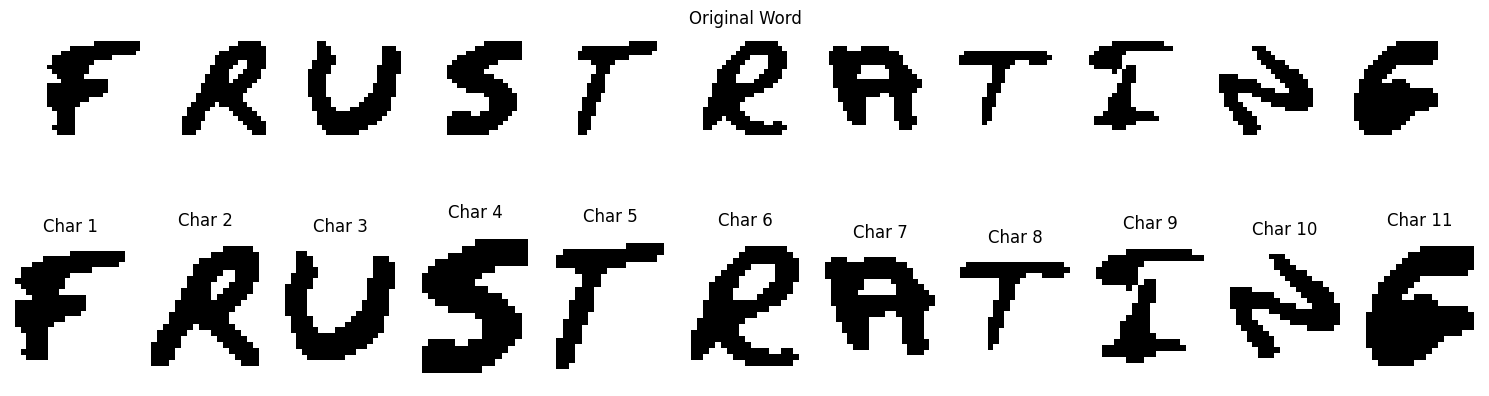

In [70]:
word_images = segment_words(preprocess_image('Data/target_images/line_2.png'))
characters = segment_characters(word_images[2])

plt.figure(figsize=(15, 5))
    
# Display the original word
plt.subplot(2, 1, 1)
plt.imshow(word_images[2], cmap='gray')
plt.title('Original Word')
plt.axis('off')
    
# Display individual characters
n_chars = len(characters)
print(n_chars)
for i, char in enumerate(characters):
        plt.subplot(2, n_chars, n_chars + i + 1)
        plt.imshow(char, cmap='gray')
        plt.title(f'Char {i+1}')
        plt.axis('off')
    
plt.tight_layout()
plt.show()

### Sentence maker

In [66]:
def make_sentence(image_path):
    sentence = ""
    # Preprocess the image
    image = preprocess_image(image_path)
    # Segment the words
    word_images = segment_words(image)
    print(len(word_images))
    # Segment the characters
    characters = [segment_characters(word) for word in word_images]
    for i in range(len(characters)):
        word = ""
        for j in range(len(characters[i])):
            char = cv2.bitwise_not(characters[i][j])
            char = cv2.resize(char, (28, 28))
            char = char.reshape(28, 28, 1)
            char = char / 255.0
            # Predict the character
            print(characters[i][j].shape)
            predicted_character = predict_character(model, char)
            word += predicted_character
        sentence += word + " "
    return sentence


### demo of sentence maker

In [71]:
sentence = make_sentence('Data/target_images/line_2.png')
print(sentence)

364
280
20
(6, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
(23, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
(18, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(22, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
(24, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
(24, 18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
(24, 19)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(24, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
(22, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(20, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
(23, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
(23, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
(24, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(21, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(24, 19)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(24, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(18, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(24, 15)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(2

### Debugging part

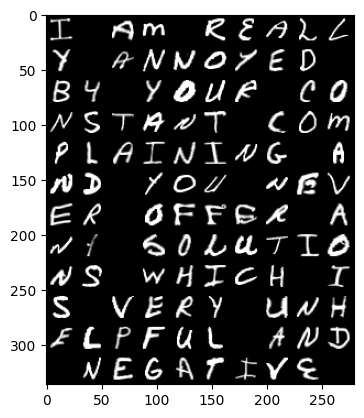

In [39]:

image = cv2.imread('Data/target_images/line_1.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

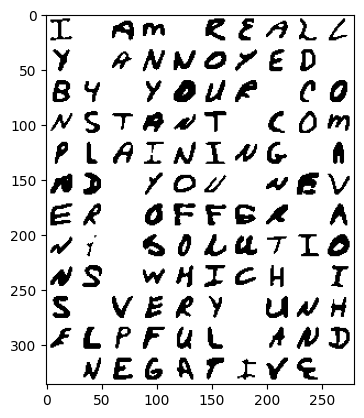

In [40]:
image = preprocess_image('Data/target_images/line_1.png')
plt.imshow(image, cmap='gray')
plt.show()

336
280


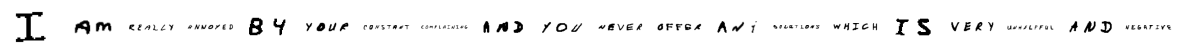

In [44]:
word_images = segment_words(image)
plt.figure(figsize=(15, 5))
for i, word in enumerate(word_images):
    plt.subplot(1, len(word_images), i+1)
    plt.imshow(word, cmap='gray')
    plt.axis('off')

(24, 18)
(24, 14)
(20, 20)
(24, 16)
(24, 17)
(24, 16)


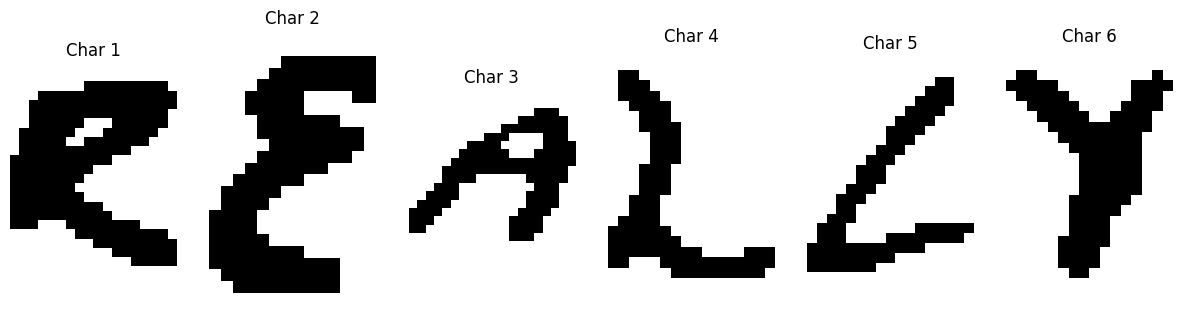

In [49]:
characters = segment_characters(word_images[2])
# plot them on different line
plt.figure(figsize=(15, 5))
for i, char in enumerate(characters):
    print(char.shape)
    plt.subplot(1, len(characters), i+1)
    plt.imshow(char, cmap='gray')
    plt.title(f'Char {i+1}')
    plt.axis('off')

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0. 

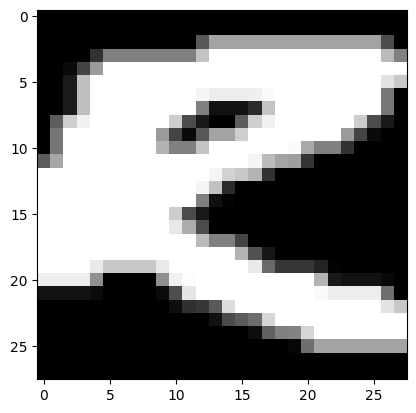

In [62]:
char = cv2.bitwise_not(characters[0])
char = cv2.resize(char, (28, 28))
char = char.reshape(28, 28, 1)
char = char / 255.0

print(char)
print(char.shape)
plt.imshow(char, cmap='gray')
plt.show()

In [63]:
predicted_char = predict_character(model, char)
print(predicted_char)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
R


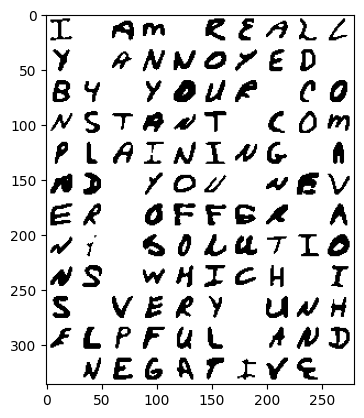

In [20]:
# Example usage
image_path = 'Data/target_images/line_1.png'
binary_image = preprocess_image(image_path)
character_segments = segment_characters(binary_image)
# character_positions = [(x, segment) for x, segment in enumerate(character_segments)]
# words = group_characters_to_words(character_positions)
# recognized_text = recognize_words(words)
# sentences = convert_to_sentences(recognized_text)

# for sentence in sentences:
#     print(sentence)

## Sentiment Analyser

### Libraries required

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

### Loading the data

In [74]:
data = pd.read_csv('Data/sentiment_analysis_dataset.csv')

In [76]:
X = data['line']
y = data['sentiment']

In [77]:
print(X.shape)
print(y.shape)

(30,)
(30,)


### Split the dataset

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(24,)
(6,)
(24,)
(6,)


### Create word vectors

In [80]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Train Naive Bayes classifier

In [81]:
classifier = MultinomialNB()
classifier.fit(X_train_vectorized, y_train)

MultinomialNB()

In [82]:
y_pred = classifier.predict(X_test_vectorized)

# Print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

       Angry       0.50      0.50      0.50         2
       Happy       0.50      0.50      0.50         2
     Neutral       1.00      1.00      1.00         2

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



## Testing overall

In [84]:
target_labels = pd.read_csv('Data/target_labels.csv')
target_labels.head()

,file,sentiment
0,line_1.png,Angry
1,line_2.png,Angry
2,line_3.png,Happy
3,line_4.png,Happy
4,line_5.png,Neutral


In [86]:
image_paths = target_labels['file']
image_paths.head()

0    line_1.png
1    line_2.png
2    line_3.png
3    line_4.png
4    line_5.png
Name: file, dtype: object

In [88]:
sentiments = []
for image_path in image_paths:
    image_path = "Data/target_images/" + image_path
    sentence = make_sentence(image_path)
    print(sentence)
    sentiment = classifier.predict(vectorizer.transform([sentence]))[0]
    sentiments.append(sentiment)

336
280
20
(24, 22)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
(24, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
(18, 25)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
(24, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
(24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
(20, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
(24, 18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
(24, 19)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
(24, 18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
(20, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(22, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(20, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
(24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
(24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
(24, 18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(23, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
(24, 16)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
(24, 22)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
(24, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
(24, 22)
1/1 ━━━━━━

In [90]:
## calculate the accuracy of the model
accuracy = accuracy_score(target_labels['sentiment'], sentiments)
print("Accuracy:", accuracy)

## classification report
print("\nClassification Report:\n", classification_report(target_labels['sentiment'], sentiments))

Accuracy: 0.8333333333333334

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.50      0.67         2
       Happy       0.67      1.00      0.80         2
     Neutral       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



In [92]:
for i in range(len(sentiments)):
    print(f"Actual: {target_labels['sentiment'][i]}")
    print(f"Predicted: {sentiments[i]}")
    print()

Actual: Angry
Predicted: Happy

Actual: Angry
Predicted: Angry

Actual: Happy
Predicted: Happy

Actual: Happy
Predicted: Happy

Actual: Neutral
Predicted: Neutral

Actual: Neutral
Predicted: Neutral

